# Load the Dataset

In [1]:
!kaggle datasets download -d sixhky/open-images-bus-trucks -p ./Dataset
!unzip ./Dataset/open-images-bus-trucks.zip -d ./Dataset

Dataset URL: https://www.kaggle.com/datasets/sixhky/open-images-bus-trucks
License(s): unknown
open-images-bus-trucks.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ./Dataset/open-images-bus-trucks.zip
replace ./Dataset/df.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


# Import Libraries

In [2]:
from torchvision import transforms, models, datasets
from torchvision.ops import nms # Non-Maximum Suppression
from torch_snippets import *
from torch_snippets.torch_loader import Report

# Set the device

In [4]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# read the csv file

In [8]:
import pandas as pd
image_root_directory = './Dataset/images/images'
Raw_Information = pd.read_csv('./Dataset/df.csv')
Raw_Information.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


# define a custom dataset class to read samples

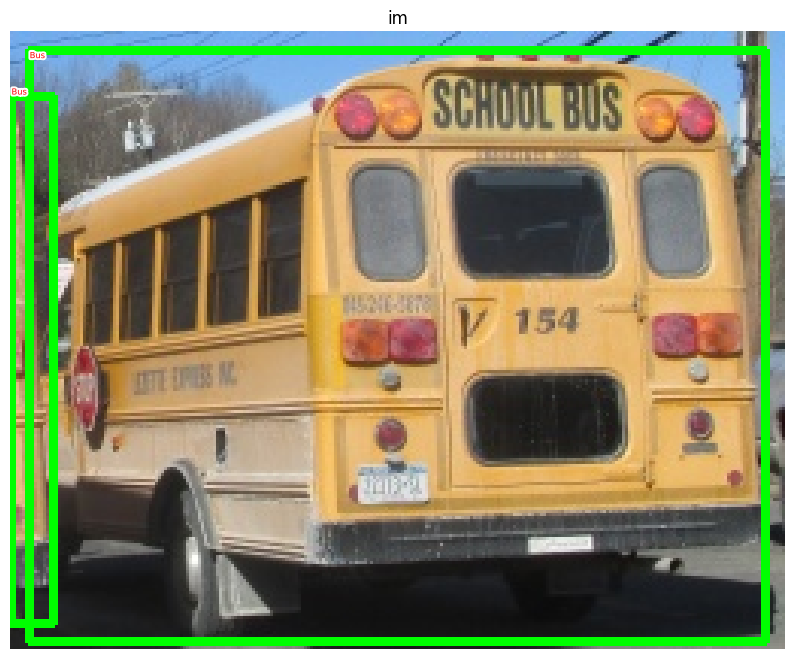

In [18]:
import cv2
from torch.utils.data import Dataset

class reading_samples(Dataset):
    def __init__(self, dataframe, image_folder_root : str = image_root_directory):
        """
        A custom dataset class for loading images, labels, and bounding boxes from a CSV file and image folder.


       Args:
        dataframe (pandas.DataFrame): A DataFrame containing the metadata for the dataset, 
            including image filenames, labels, and bounding box coordinates ('XMin', 'YMin', 'XMax', 'YMax').
        image_folder_root (str): The root directory where the image files are stored. The file paths 
            in the DataFrame should be relative to this root.
        
        Returns:
                image (np.ndarray): The image corresponding to the given index, read and converted from BGR to RGB.
                image_boxes (list of list): A list of bounding box coordinates in the format [XMin, YMin, XMax, YMax].
                    The coordinates are scaled to the image dimensions.
                image_classes (list): label of bounding boxes in the image.
                path2image (str): The file path to the image.
        """
        self.root = image_folder_root
        self.df = dataframe
        self.images = dataframe['ImageID'].unique()
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        image_id = self.images[idx]
        path2image = f'{self.root}/{image_id}.jpg'
        # we need to convert format of the read image from BGR to RGB in cv2
        image = cv2.imread(path2image, # path 2 the image
                           1 # color format of BGR
                           ) [...,::-1]  # ... -->  all rows and columns  while ::-1 --> reverse the order of the last axis from BRG to RGB
        hight, width,_ = image.shape
        # The copy() method is a built-in method of pandas DataFrame and Series objects. It creates a copy of the object and is unrelated to Python's copy module.
        image_inf = self.df.copy() 
        # extract information of the image
        image_inf = image_inf[image_inf['ImageID'] == image_id]
        image_boxes = image_inf['XMin,YMin,XMax,YMax'.split(',')].values
       
        image_boxes = (image_boxes * np.array([width,hight,width,hight])).astype(np.uint16).tolist()
        image_classes = image_inf['LabelName'].values.tolist()
        return image, image_boxes, image_classes, path2image
        
# sample image
sample = reading_samples(dataframe = Raw_Information)
random_image_idx = np.random.randint(0, len(sample))
im, bbs, clss,_ = sample[random_image_idx]
show(im, bbs = bbs, texts = clss, sz = 10)

# define functions for extracting IoU and candidate boxes

In [26]:
# define extracting IoU and candidate boxes
import selectivesearch
def extract_candidate_boxes (input_img):
    label, regions =  selectivesearch.selective_search(input_img, scale = 200, min_size = 100)
    area = np.prod(input_img.shape[:2]) # H, W, C
    candidates= []
    for region in regions:
        # choose candidate region that has over 5% of the total image area and less than or equal to 100% of the image area
        # This is an entry in each dictionary within the regions list that specifies the bounding box of the region. It typically contains four values: (x, y, width, height) that define the rectangle that bounds the region.
        if region['rect'] in candidates:  # do not choose repeated candidate region
            continue
        if region['size'] < (0.05 * area): # do not choose candidate region that has less than 5% cover of the  image
            continue
        if region['size'] > (1*area): # do not choose candidate region which is larger than the size of the image
            continue
        # x, y, w, h = region['rect']
        candidates.append(list(region['rect']))
    return candidates

def extract_iou (boxA, boxB, epsilon = 1e-6):
    x_min = max(boxA[0], boxB[0])
    y_min = max(boxA[1], boxB[1])
    x_max = min (boxA[2], boxB[2])
    y_max = max(boxA[3], boxB[3])
    width = (x_max - x_min)
    height = (y_max - y_min)
    
    if (width < 0) or (height < 0):
        return 0
    intersection_area = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    union_area = area_a + area_b - intersection_area
    iou = intersection_area / (union_area + epsilon)
    return iou

In [27]:
file_paths, gt_bounding_box, classes, Deltas, region_proposal_locations, IOUS = [],[],[],[],[],[]
# because of the source limitations, we use only 600 of samples
number_samples = 600
for idx_image, (image, bbs, labels, fpath) in enumerate (sample):
    if (idx_image == number_samples):
        break
    H, W, _ = image.shape
    # extract candidates from the image
    candidates = extract_candidate_boxes(image)
    candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])
    # save ious, rois, deltas, and classes for each candidate
    ious, rois, clss, deltas = [], [], [], []
    # Store the IoU of all candidates
    ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T
    # Loop through each candidate and store Xmin, Ymin, Xmax, and Ymax values of a candidate
    for candidate_idx, candidate in enumerate(candidates):
        xmin_candidate, ymin_candidate, xmax_candidate, ymax_candidate = candidate
        # Values of IoU for a specific candidate box and all ground truth bounding box
        candidate_ious = ious[candidate_idx]
        # find the index of a candidate with the highest IoU and the corresponding ground truth
        best_iou_at = np.argmax(candidate_ious)
        # extract the highest IoU value
        best_iou = candidate_ious[best_iou_at]
        # coordinates of the ground truth bounding box
        best_bb = xmin_gt,ymin_gt,xmax_gt,ymax_gt = bbs[best_iou_at]
        
        # if IoU (best_iou) is greater than a threshold, we assign the label of the class corresponding to the candidate, and the background otherwise
        if best_iou > 0.3 :
            clss.append(labels[best_iou_at])
        else:
            clss.append('background')
        
        # Fetch of the offsets needed(delta) to transform the current proposal into the candidate
        delta = np.array([xmin_gt-xmin_candidate,
                          ymin_gt-ymin_candidate, 
                          xmax_gt-xmax_candidate, 
                          ymax_gt- ymax_candidate]) / np.array([W,H,W,H])
        deltas.append(delta)
        rois.append(candidate / np.array([W,H,W,H]))
    
    file_paths.append(fpath)
    IOUS.append(ious)
    region_proposal_locations.append(rois)
    classes.append(clss)
    Deltas.append(deltas)
    gt_bounding_box.append(bbs)
    
file_paths = [f'{image_root_directory}/{stem(f)}.jpg' for f in file_paths] 
file_paths, gt_bounding_box, classes, Deltas, region_proposal_locations = [item for item in [file_paths, gt_bounding_box, classes, Deltas, region_proposal_locations]]       

/home/saeid23/anaconda3/envs/torch-based/lib/python3.8/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/home/saeid23/anaconda3/envs/torch-based/lib/python3.8/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/home/saeid23/anaconda3/envs/torch-based/lib/python3.8/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to 

In [28]:
# convert labels from name into their corresponding indices.
# background class = 0
# bus class = 1
# truck class = 2
targets = pd.DataFrame(flatten(classes), columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']

# Creating the training data

In [29]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1) # C, H, W
    img = normalize(img)
    return img.to(device).float()
# decode the prediction
def decode(_y):
    _, preds = _y.max(-1)
    return preds

# Create a Dataset

In [30]:
from torch.utils.data import TensorDataset, DataLoader

class RCNNDataset(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas
    def __len__(self):
        return len(self.fpaths)
    def __getitem__(self, ix):
        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath, 1)[...,::-1]
        H, W, _ = image.shape
        sh = np.array([W,H,W,H])
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        bbs = (np.array(rois)*sh).astype(np.uint16)
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        crops = [image[y:Y,x:X] for (x,y,X,Y) in bbs]
        return image, crops, bbs, labels, deltas, gtbbs, fpath
    def collate_fn(self, batch):
        input, rois, rixs, labels, deltas = [], [], [], [], []
        for ix in range(len(batch)):
            image, crops, image_bbs, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
            crops = [cv2.resize(crop, (224,224)) for crop in crops]
            crops = [preprocess_image(crop/255.)[None] for crop in crops]
            input.extend(crops)
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
        input = torch.cat(input).to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input, labels, deltas
    
n_train = 9*len(file_paths)//10
train_ds = RCNNDataset(file_paths[:n_train], region_proposal_locations[:n_train], classes[:n_train], Deltas[:n_train], gt_bounding_box[:n_train])
test_ds = RCNNDataset(file_paths[n_train:], region_proposal_locations[n_train:], classes[n_train:], Deltas[n_train:], gt_bounding_box[n_train:])


train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)

# R-CNN network architecture

In [32]:
import torch.nn as nn

vgg_backbone = models.vgg16(pretrained=True)
vgg_backbone.classifier = nn.Sequential()
for param in vgg_backbone.parameters():
    param.requires_grad = False
vgg_backbone.eval().to(device)

class RCNN(nn.Module):
    def __init__(self):
        super().__init__()
        feature_dim = 25088
        self.backbone = vgg_backbone
        self.cls_score = nn.Linear(feature_dim, len(label2target))
        self.bbox = nn.Sequential(
              nn.Linear(feature_dim, 512),
              nn.ReLU(),
              nn.Linear(512, 4),
              nn.Tanh(),
            )
        self.cel = nn.CrossEntropyLoss()
        self.sl1 = nn.L1Loss()
    def forward(self, input):
        feat = self.backbone(input)
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat)
        return cls_score, bbox
    def calc_loss(self, probs, _deltas, labels, deltas):
        detection_loss = self.cel(probs, labels)
        ixs, = torch.where(labels != 0)
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        self.lmb = 10.0
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
        else:
            regression_loss = 0
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss

/home/saeid23/anaconda3/envs/torch-based/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/saeid23/anaconda3/envs/torch-based/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/saeid23/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:50<00:00, 10.9MB/s] 


# train the model

In [33]:
import torch.optim as optim

def train_batch(inputs, model, optimizer, criterion):
    input, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    _clss, _deltas = model(input)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

@torch.no_grad()
def validate_batch(inputs, model, criterion):
    input, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input)
        loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
        _, _clss = _clss.max(-1)
        accs = clss == _clss
    return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

rcnn = RCNN().to(device)
criterion = rcnn.calc_loss
optimizer = optim.SGD(rcnn.parameters(), lr=1e-3)
n_epochs = 5
log = Report(n_epochs)

/tmp/ipykernel_4139/458195658.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  deltas = torch.Tensor(deltas).float().to(device)


EPOCH: 5.000  val_loss: 2.162  val_loc_loss: 1.012  val_regr_loss: 0.115  val_acc: 0.523  (16878.66s - 0.00s remaining)g))

100%|██████████| 106/106 [00:00<00:00, 7832.91it/s]


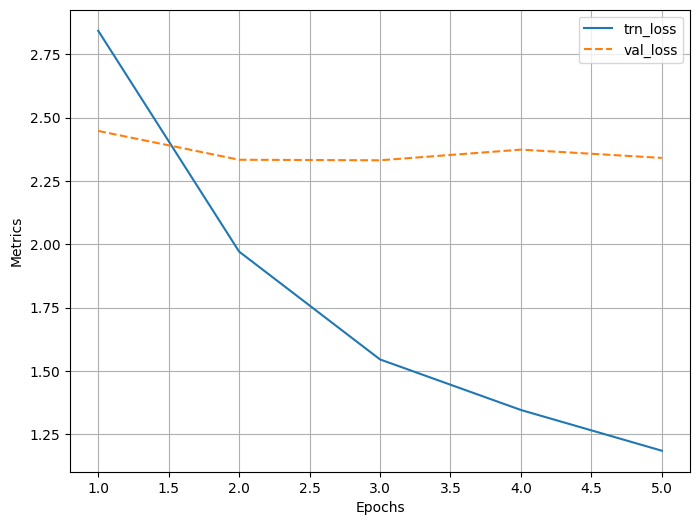

In [34]:
for epoch in range(n_epochs):

    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, loc_loss, regr_loss, accs = train_batch(inputs, rcnn, 
                                                      optimizer, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss, 
                   trn_regr_loss=regr_loss, 
                   trn_acc=accs.mean(), end='\r')
        
    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        _clss, _deltas, loss, \
        loc_loss, regr_loss, accs = validate_batch(inputs, 
                                                rcnn, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss, 
                val_regr_loss=regr_loss, 
                val_acc=accs.mean(), end='\r')

# Plotting training and validation metrics
log.plot_epochs('trn_loss,val_loss'.split(','))

/home/saeid23/anaconda3/envs/torch-based/lib/python3.8/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


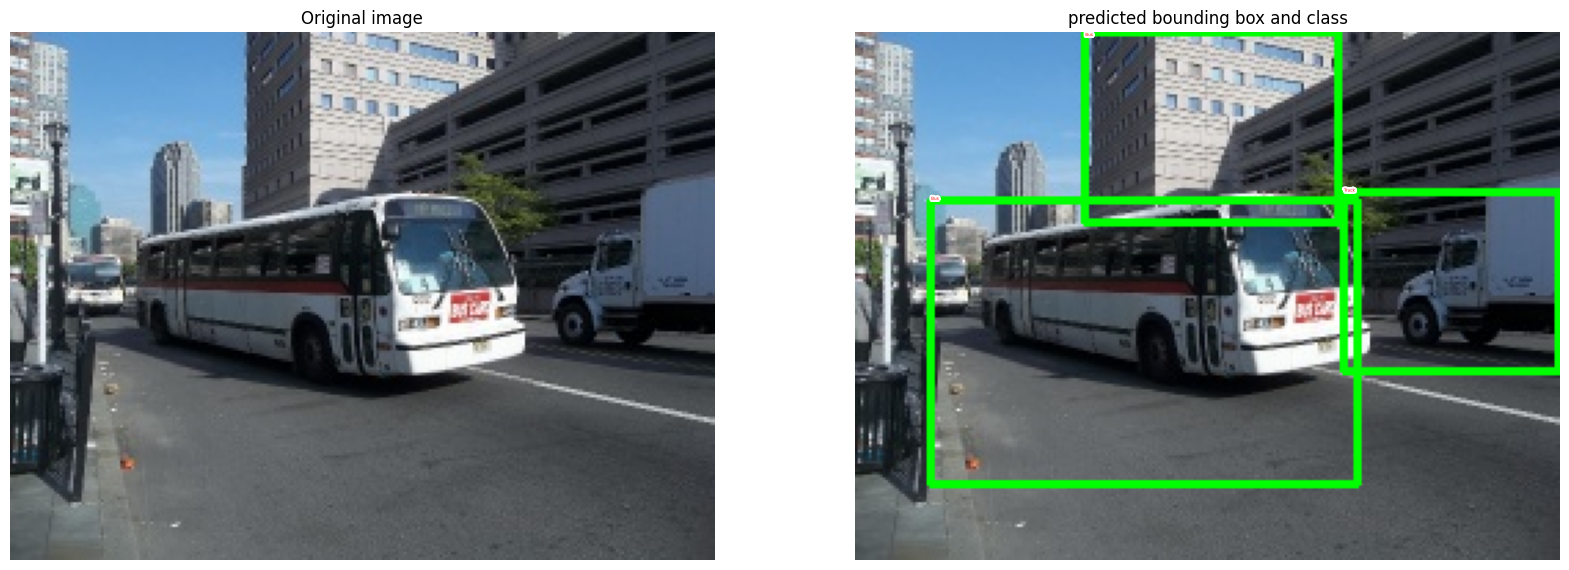

((27, 61, 182, 164), 'Bus', 0.9749268)

In [37]:
import matplotlib.pyplot as plt
def test_predictions(filename, show_output=True):
    img = np.array(cv2.imread(filename, 1)[...,::-1])
    candidates = extract_candidate_boxes(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = []
    for candidate in candidates:
        x,y,X,Y = candidate
        crop = cv2.resize(img[y:Y,x:X], (224,224))
        input.append(preprocess_image(crop/255.)[None])
    input = torch.cat(input).to(device)
    with torch.no_grad():
        rcnn.eval()
        probs, deltas = rcnn(input)
        probs = torch.nn.functional.softmax(probs, -1)
        confs, clss = torch.max(probs, -1)
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]

    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = (candidates + deltas).astype(np.uint16)
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(confs) == 0 and not show_output:
        return (0,0,224,224), 'background', 0
    if len(confs) > 0:
        best_pred = np.argmax(confs)
        best_conf = np.max(confs)
        best_bb = bbs[best_pred]
        x,y,X,Y = best_bb
    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title('Original image')
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    ax[1].set_title(target2label[clss[best_pred]])
    show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1], title='predicted bounding box and class')
    plt.show()
    return (x,y,X,Y),target2label[clss[best_pred]],best_conf


image, crops, bbs, labels, deltas, gtbbs, fpath = test_ds[7]
test_predictions(fpath)